In [12]:
import pandas as pd
fake = pd.read_csv("data/Fake.csv")
real = pd.read_csv("data/True.csv")

print("Fake shape:", fake.shape)
print("Real shape:", real.shape)
fake.head()
fake["label"] = 0   # Fake news
real["label"] = 1   # Real news




Fake shape: (23481, 4)
Real shape: (21417, 4)


In [15]:
import pandas as pd

data = pd.concat([fake, real], axis=0)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(data.shape)
data.head()
data = pd.concat([fake, real], axis=0)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)



(44898, 5)


In [16]:
print(data.columns)


Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [17]:
print(data.columns)
data.head()


Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [18]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


In [22]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and len(word) > 2
    ]
    return " ".join(words)



In [23]:
data["clean_text"] = data["text"].apply(clean_text)


In [25]:
data[["text", "clean_text"]].head()


,text,clean_text
0,"21st Century Wire says Ben Stein, reputable pr...",century wire say ben stein reputable professor...
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters president donald trump remo...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello ...
3,"On Monday, Donald Trump once again embarrassed...",monday donald trump embarrassed country accide...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters presidential candidat...


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [28]:
X = data["clean_text"]   # input (text)
y = data["label"]        # output (0 = Fake, 1 = Real)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

print(X_tfidf.shape)


(44898, 5000)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(35918, 5000) (8980, 5000)


In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [31]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9842984409799554
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4710
           1       0.98      0.99      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



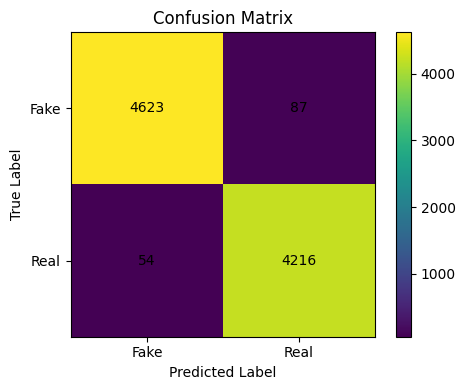

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Fake", "Real"]
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [33]:
def predict_news(news_text):
    # 1. Clean the input text
    cleaned = clean_text(news_text)
    
    # 2. Convert text to TF-IDF vector
    vector = vectorizer.transform([cleaned])
    
    # 3. Predict using trained model
    prediction = model.predict(vector)[0]
    
    # 4. Return readable output
    if prediction == 0:
        return "FAKE NEWS ❌"
    else:
        return "REAL NEWS ✅"


In [34]:
sample_text = """
The government has announced a new policy aimed at improving
education infrastructure across rural areas, with increased funding
and teacher training programs.
"""

predict_news(sample_text)


'FAKE NEWS ❌'

In [35]:
fake_text = """
Breaking: Scientists confirm drinking hot water cures all diseases
overnight, according to secret studies hidden from the public.
"""

predict_news(fake_text)


'FAKE NEWS ❌'

In [36]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 0.9293986636971047
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4710
           1       0.93      0.93      0.93      4270

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [37]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


SVM Accuracy: 0.9934298440979955
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4710
           1       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [38]:
results = {
    "Logistic Regression": accuracy_score(y_test, y_pred),
    "Naive Bayes": accuracy_score(y_test, nb_pred),
    "SVM": accuracy_score(y_test, svm_pred)
}

for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


Logistic Regression: 0.9843
Naive Bayes: 0.9294
SVM: 0.9934


In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [40]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    
    classes = ["Fake", "Real"]
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


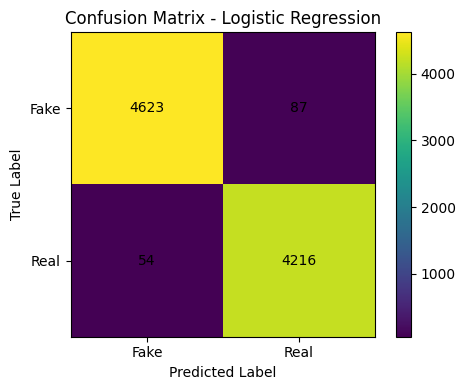

In [41]:
plot_confusion_matrix(
    y_test,
    y_pred,
    "Confusion Matrix - Logistic Regression"
)


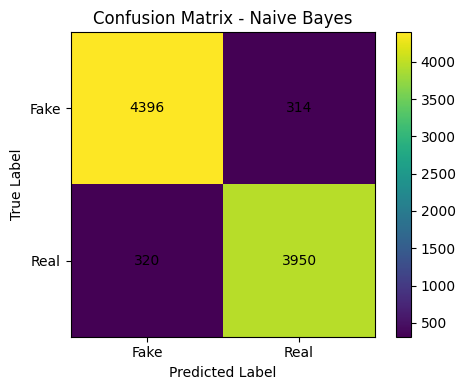

In [42]:
plot_confusion_matrix(
    y_test,
    nb_pred,
    "Confusion Matrix - Naive Bayes"
)


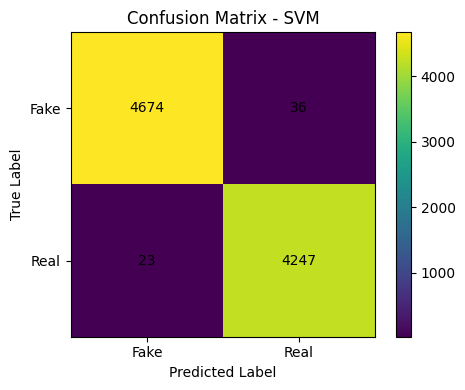

In [43]:
plot_confusion_matrix(
    y_test,
    svm_pred,
    "Confusion Matrix - SVM"
)
